<a href="https://colab.research.google.com/github/neurologic/NeurophysiologyModules/blob/main/EMG_MotorUnits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Introduction

In vertebrates, motor units are comprised of a single motor neuron and the muscle fibers it innervates. In this notebook you will explore data in which sub-overt movements were made to isolate the physiological activity (spiking) of individual motor units.

To aquire this dataset, the two contacts of a differential emg electrode were placed above the interossei medial to the second digit (at the two circles shown below).

<img src='https://drive.google.com/uc?export=view&id=1o2BcBz3d7XF0OzCgH93gjIBrDnpJt89Q' width=300px>

Then, the intention to move the second digit (without much, if any, overt movement) was sufficient to recruit regular activity from only a couple motor units. Because minimal motor units were recruited, we can isolate their spiking activity. 

# 2) Some necessary preparatory steps.

In [ ]:
#@markdown <b>TASK: </b> RUN this cell to set up the notebook (import packages, etc)
# In Python, anything with a "#" in front of it is code annotation,
# and is not read by the computer.
# You can run a cell (this box) by pressing ctrl-enter or shift-enter.
# You can also run a cell by clicking the play button in the menu bar 
# at the top of the page (single right arrow, not double).
# Click in this cell and then press shift and enter simultaneously.
# This print function below allows us to generate a message.
print('Nice work!')

# No need to edit anything in this code cell
#################################

import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.signal import find_peaks
from copy import deepcopy
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import csv
from scipy.signal import hilbert,medfilt,resample
from scipy.io import wavfile
from sklearn.decomposition import PCA
import scipy
import seaborn as sns
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Nice work!
Task completed at 2022-01-12 13:25:51.328935-05:00


In [ ]:
#@markdown <b>TASK: </b> RUN this cell to mount your Google Drive, where you will access the raw data from.
#@markdown > Follow all instructions as prompted by pop-ups.
from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Task completed at 2022-01-12 13:32:36.092209-05:00


# 3) Get the data.  

In [ ]:
#@markdown <b>TASK: </b> Select one of the data files from the dropdown below:
filename = "BYB_Recording_D2_minstim_sustainedstraighten.wav"  #@param ['pick a file', 'BYB_Recording_D2_ipsi_minstim_trial0.wav', 'BYB_Recording_D2_ipsi_minstim_trial1.wav', 'BYB_Recording_D2_ipsi_minstim_trial2.wav','BYB_Recording_D2_minstim_sustainedstraighten.wav']
#@markdown <b>TASK: </b> After you have selected a file, <b> hit the play button to RUN this cell </b>

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

data_folder = "/content/drive/Shareddrives/BIOL358/Data/Interossei_1chan_MotorUnitIsolation"

emg_path = Path(data_folder) / filename
#%% import data
# df_analog_ = pd.read_csv(emg_path.expanduser().resolve(), sep=',')
sample_rate, samples = wavfile.read(emg_path)
xtime = np.linspace(0,len(samples)/sample_rate,len(samples))

filtert = int(0.01*sample_rate)
y = np.abs(samples) #takes the absolute value of 
samples_envelope = scipy.ndimage.gaussian_filter(y,filtert)
samples_envelope =(samples_envelope - np.mean(samples_envelope)) / np.std(samples_envelope)

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

print('Now be a bit patient while it plots.')
fig = go.Figure()
fig.add_trace(go.Scatter(x = xtime, y = samples,line_color='black',name='emg0'))
fig.update_layout(xaxis_title="time(seconds)", yaxis_title='amplitude',width=800, height=500)

# 4) First, we need to process the data a bit.
You need to set a detection threshold that will be used to detect electrical events produced by motor units in the interossei muscle.

You detected 736 events above threshold.
Tasks completed at 2022-01-12 13:27:40.156108-05:00


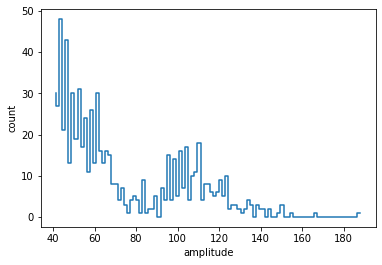

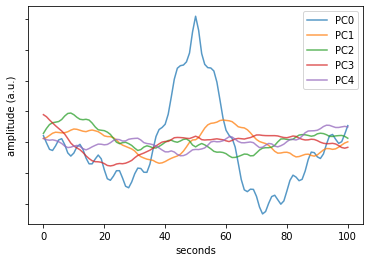

In [ ]:
#@markdown <b>TASK: </b> Type in an appropriate event threshold amplitude for detection.
threshold = 40  #@param {type: "number"}
#@markdown <b>TASK: </b> Then from the dropdown, select a polarity (whether peaks are up "1" or down "-1")
peaks = "up"  #@param ['select peak direction','up', 'down']
#@markdown <b>TASK: </b> Finally, RUN this cell to set these values.
spike_detection_threshold = threshold
if peaks=='up': polarity = 1
if peaks=='down':polarity=-1

#@markdown After the values are set, the emg signal will be processed to detect events (peaks).
#@markdown "PCA" (principle component analysis) to detect similarities among waveforms for sets of events.
#@markdown <br> You will see a histogram of event peak amplitudes as well as a plot of waveform PCs (principle components).
min_isi = 0.005 #seconds
peaks,props = find_peaks(polarity * samples,height=spike_detection_threshold, 
                         prominence = spike_detection_threshold, distance=(min_isi*sample_rate))
peaks_t = peaks/sample_rate
df_props = pd.DataFrame({
        'height': props['peak_heights'],
        'spikeT' : peaks_t,
        'spikeInd' : peaks
        # 'widths' : props['widths']/fs
            })
n,bins = np.histogram(df_props['height'],bins = 100) # calculate the histogram
bins = bins[1:]
hfig,ax = plt.subplots(1)
ax.step(bins,n)
ax.set_ylabel('count')
ax.set_xlabel('amplitude')

windur = 0.005
winsamp = int(windur*sample_rate)
spkarray = []
for i in df_props['spikeInd'].values:
    spkarray.append(samples[i-winsamp : i+winsamp+1])

df = pd.DataFrame(np.asarray(spkarray).T)
df_norm =(df - df.mean()) / df.std() # normalize for pca

n_dim = 5
n_components=np.min([n_dim,df.shape[1]]) # if try to take more components than have channels, use amount of channels
pca = PCA(n_components=n_components)
pca.fit(df_norm)
df_pca = pd.DataFrame(pca.transform(df), columns=['PC%i' % i for i in range(n_components)], index=df.index)
print('You detected %i events above threshold.' %len(df.columns))
#print(You have transformed this dataset into %i principle components.' %(len(df.columns),n_components))

loadings = pd.DataFrame(pca.components_.T, columns=df_pca.columns, index=df.columns)
df_data = loadings.join(df_props['height'])

hfig,ax = plt.subplots(1)
ax.set_xlabel('seconds')
ax.set_ylabel('amplitude (a.u.)')
ax.set_yticklabels([])
for c in df_pca.columns:
    ax.plot(df_pca[c],label = c,alpha = 0.75)
plt.legend(bbox_to_anchor=(1, 1));

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))


# 5) Now, we will categorize the events based on waveform and amplitude.

246 spikes in cluster number 0
102 spikes in cluster number 1
194 spikes in cluster number 2
28 spikes in cluster number 3
106 spikes in cluster number 4
60 spikes in cluster number 5
Tasks completed at 2022-01-12 13:30:55.918530-05:00


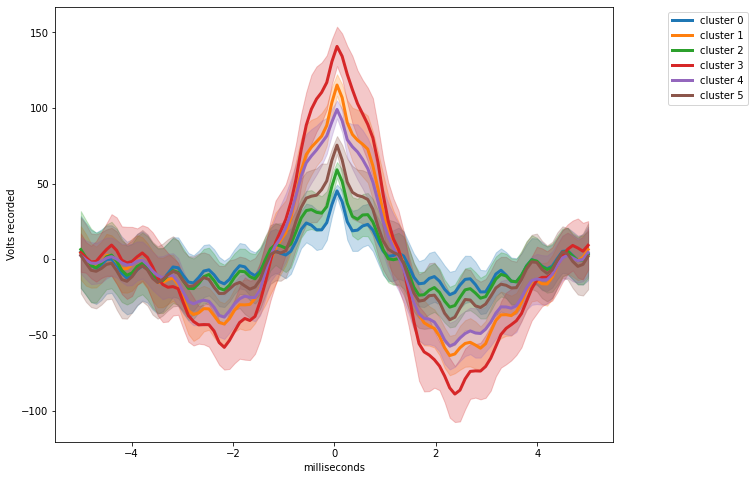

In [ ]:
#@markdown Let's start by over-splitting the events into 6 clusters.
#@markdown <br><b>TASK: </b> RUN this cell to cluster events categorically based on waveform shape and amplitude. 
#@markdown <br>As a result, you will see a plot of the mean waveform from each cluster (with standard deviation shaded)
number_of_clusters = 6
# No need to edit below this line
#################################

kmeans = KMeans(n_clusters=number_of_clusters).fit(df_data)
df_props['peaks_t'] = peaks_t
df_props['cluster'] = kmeans.labels_

winsamps = int(windur * sample_rate)
x = np.linspace(-windur,windur,winsamps*2)*1000
hfig,ax = plt.subplots(1,figsize=(10,8))
ax.set_ylabel('Volts recorded')
ax.set_xlabel('milliseconds')

# fig = go.Figure()

for k in np.unique(df_props['cluster']):
    spkt = df_props.loc[df_props['cluster']==k]['peaks_t'].values
    spkt = spkt[(spkt>windur) & (spkt<(len((samples)/sample_rate)-windur))]
    print(str(len(spkt)) + " spikes in cluster number " + str(k))
    spkwav = np.asarray([samples[(int(t*sample_rate)-winsamps):(int(t*sample_rate)+winsamps)] for t in spkt])
    wav_u = np.mean(spkwav,0)
    wav_std = np.std(spkwav,0)
    # fig.add_trace(go.Scatter(x = x, y = wav_u,line_color=pal[k],name='cluster ' + str(k)),
    #          row=1,col=1)
    ax.plot(x,wav_u,linewidth = 3,label='cluster '+ str(k),color=pal[k])
    ax.fill_between(x, wav_u-wav_std, wav_u+wav_std, alpha = 0.25,color=pal[k])
# fig.update_layout(xaxis_title="time(seconds)", yaxis_title='amplitude',width=500, height=500)
plt.legend(bbox_to_anchor=[1.25,1]);

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))


If there are multiple spike clusters you want to merge into a single cell class, *edit and run* the cell below.

> **merge_cluster_list** = a list of the clusters (identified by numbers associated with the colors specified in the legend above).
  - **For example**, the folowing list would merge clusters 0 and 2 together and 1, 4, and 3 together: <br>
     **merge_cluster_list = [[0,2],[1,4,3]]**
  - For each merge group, the first cluster number listed will be the re-asigned cluster number for that group (for example, in this case you would end up with a cluster number 0 and a cluster number 1). 
  

In [ ]:
#@markdown <b>TASK: </b> Below, create your list (of sublists) of clusters to merge.
#@markdown >Just leave out from the list any clusters that you want unmerged.
merge_cluster_list = [[5,2,0],[1,4]] #@param
#@markdown <b> TASK: </b> Then, RUN the cell to merge clusters as specified.

for k_group in merge_cluster_list:
    for k in k_group:
        df_props.loc[df_props['cluster']==k,'cluster'] = k_group[0]
print('you now have the following clusters: ' + str(np.unique(df_props['cluster'])))

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))


you now have the following clusters: [1 3 5]
Tasks completed at 2022-01-12 13:31:19.861162-05:00


208 spikes in cluster number 1
28 spikes in cluster number 3
500 spikes in cluster number 5
Tasks completed at 2022-01-12 13:31:24.291423-05:00


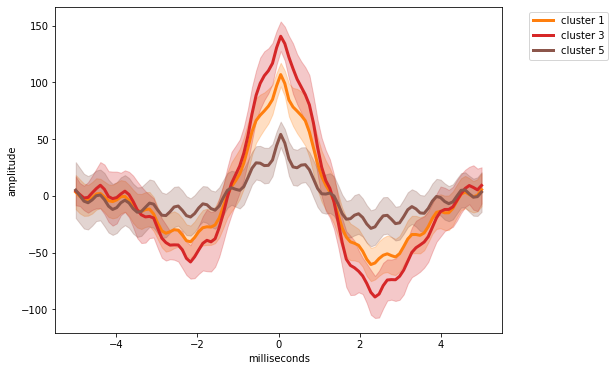

In [ ]:
#@markdown <b> TASK: </b> Now, RUN this cell to plot the average waveform for your new clusters.
##@markdown And to plot a color-coded scatter of each detected and categorized emg event.
winsamps = int(windur * sample_rate)
x = np.linspace(-windur,windur,winsamps*2)*1000
hfig,ax = plt.subplots(1,figsize=(8,6))
ax.set_ylabel('amplitude')
ax.set_xlabel('milliseconds')

# fig = go.Figure()

for k in np.unique(df_props['cluster']):
    spkt = df_props.loc[df_props['cluster']==k]['peaks_t'].values
    spkt = spkt[(spkt>windur) & (spkt<(len((samples)/sample_rate)-windur))]
    print(str(len(spkt)) + " spikes in cluster number " + str(k))
    spkwav = np.asarray([samples[(int(t*sample_rate)-winsamps):(int(t*sample_rate)+winsamps)] for t in spkt])
    wav_u = np.mean(spkwav,0)
    wav_std = np.std(spkwav,0)
    # fig.add_trace(go.Scatter(x = x, y = wav_u,line_color=pal[k],name='cluster ' + str(k)),
    #          row=1,col=1)
    ax.plot(x,wav_u,linewidth = 3,label='cluster '+ str(k),color=pal[k])
    ax.fill_between(x, wav_u-wav_std, wav_u+wav_std, alpha = 0.25,color=pal[k])
# fig.update_layout(xaxis_title="time(seconds)", yaxis_title='amplitude',width=500, height=500)
plt.legend(bbox_to_anchor=[1.25,1]);

# fig = go.Figure()
# fig.add_trace(go.Scatter(x = xtime, y = samples,line_color='black',name='emg0'))
# for i,k in enumerate(np.unique(df_props['cluster'])):
#     df_ = df_props[df_props['cluster']==k]
#     fig.add_trace(go.Scatter(x = df_['peaks_t'], y = polarity*df_['height'],line_color=pal[k],name=str(k),mode='markers'))
# fig.update_layout(xaxis_title="time(seconds)", yaxis_title='amplitude',width=800, height=400)

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))


In [ ]:
#@markdown <b>TASK: </b> If you are satisfied with your clustering,
#@markdown RUN this cell to plot: 
#@markdown 1) a scatter of event times overlaid on the raw emg signal 
#@markdown and 2) a scatter of instantaneous spike rate for each cluster. 

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)


fig.add_trace(go.Scatter(x = xtime, y = samples,line_color='black',name='raw emg'),
             row=1,col=1)
for k in np.unique(df_props['cluster']):
    df_ = df_props[df_props['cluster']==k]
    fig.add_trace(go.Scatter(x = df_['peaks_t'], y = polarity*df_['height'],
                             line_color=pal[k],name=str(k),mode='markers'),row=1,col=1)


for k in np.unique(df_props['cluster']):
    df_ = df_props[df_props['cluster']==k]
    fig.add_trace(go.Scatter(x = df_['peaks_t'][1:], y = 1/np.diff(df_['peaks_t']),
                             line_color=pal[k],name='cluster ' + str(k) + ' rate',mode='markers'),
                 row=2,col=1)

print('Tasks completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))
print('Now wait a moment while the plots render.')

fig.update_layout(xaxis2_title="time(seconds)", 
                  yaxis_title='amplitude (volts)', yaxis2_title='instantaneous spike rate',
                  width=800, height=500)




Tasks completed at 2022-01-12 13:31:29.236817-05:00
Now wait a moment while the plots render.
